In [36]:
from scipy.ndimage.filters import convolve
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import cv2
import itertools
import math
from typing import Tuple, List
import canny_edge_detector as canny
from skimage.color import rgb2gray
from PIL import Image
from skimage.exposure import histogram
from matplotlib.pyplot import bar


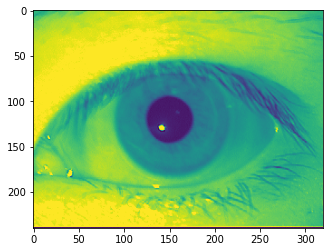

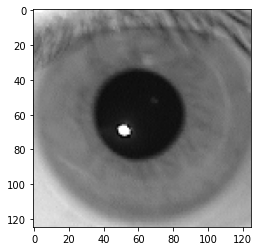

In [37]:
IMG_PATH = 'images/kelvinl1.bmp'
o_circles, inner_circles,imgr = canny.process_for_daugman(canny,IMG_PATH)
inner_radius=inner_circles[0][2], 
outer_radius=o_circles[0][2]
iris_height=outer_radius-inner_radius
iris_height=iris_height[0].astype(int)
inner_radius= inner_radius[0]


In [38]:
def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


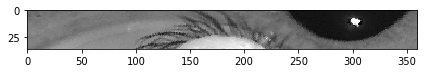

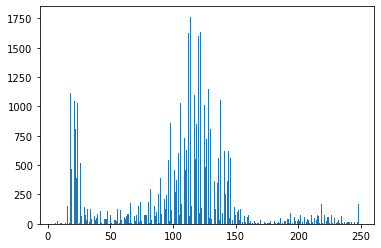

In [39]:

def daugman_normalizaiton(image, height, width, r_in, r_out):
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    # print(thetas)
    # r_out = r_in + r_out
    # Create empty flatten image
    flat = np.zeros((height, width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)

            # get coordinate of boundaries
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo

            color = image[int(Xc)][int(Yc)]  # color of the pixel

            flat[j][i] = color
    return flat


image = 'images/kelvinl3.bmp'
img = cv2.imread(image, 0)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
imgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.imshow(cimg)
image_nor = daugman_normalizaiton(imgr, iris_height, 360, inner_radius, outer_radius)
# plt.imshow(image_nor)
io.imshow(image_nor)
showHist(image_nor)
# hist = cv2.calcHist([image],[0],None,[256],[0,256])
# plt.imshow(hist)


In [40]:
 ############ Removing noise (eyelashes/ pupil) from normalized img

if(image_nor.dtype != 'uint8'): 
    image_nor = 255 * image_nor # Now scale by 255
    image_nor = image_nor.astype(np.uint8)
#get image size
G=256
N=image_nor.shape[0]
M=image_nor.shape[1]

H= [0] * G # array of histogram


#set the histogram array in H array 
size=len(list(np.histogram(image_nor, 256))[1])
start=int( list(np.histogram(image_nor, 256))[1][0])
end=int(list(np.histogram(image_nor, 256))[1][size-1])


k=0
for i in range(start,end):
    H[i]=list(np.histogram(image_nor, 256))[0][k]
    H[i]=int( H[i])
    k+=1  

#------------------------------------------------------------

# print(H)
Peak= np.max(H)
intensity_peak= np.argmax(H) #sk
# print(Peak)
# print(intensity_peak)

C= 0.1*Peak    ################################
B=0
print(Peak)
for i in range(0,len(H)):
    if H[i] <= C and i<intensity_peak: 
        print(" B calculated")
        B=i
        print(B)

print(B)
Threshold=B    ################################ 



1764
 B calculated
0
 B calculated
1
 B calculated
2
 B calculated
3
 B calculated
4
 B calculated
5
 B calculated
6
 B calculated
7
 B calculated
8
 B calculated
9
 B calculated
10
 B calculated
11
 B calculated
12
 B calculated
13
 B calculated
14
 B calculated
15
 B calculated
16
 B calculated
17
 B calculated
20
 B calculated
24
 B calculated
26
 B calculated
28
 B calculated
29
 B calculated
30
 B calculated
31
 B calculated
32
 B calculated
33
 B calculated
34
 B calculated
35
 B calculated
36
 B calculated
37
 B calculated
38
 B calculated
39
 B calculated
40
 B calculated
41
 B calculated
42
 B calculated
43
 B calculated
44
 B calculated
45
 B calculated
46
 B calculated
47
 B calculated
48
 B calculated
49
 B calculated
50
 B calculated
51
 B calculated
52
 B calculated
53
 B calculated
54
 B calculated
55
 B calculated
56
 B calculated
57
 B calculated
58
 B calculated
59
 B calculated
60
 B calculated
61
 B calculated
62
 B calculated
63
 B calculated
64
 B calculated
65
 B